## Projet de MODS206 - Nowcasting and Dynamic Factor Models

### BASTIDE Simon, RISTORCELLI Ulysse, VUJASINOVIC Thomas

In [1]:
#imports
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import plotly.graph_objects as go
import plotly.io as pio
import datetime as dt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
pio.templates.default = "plotly_white"

### i) Import et nettoyage des données

In [2]:
# Imports de capitalisations boursières des grandes entreprises du tourisme
def get_data(assets, start_date, end_date):
    """
    Récupère les données des actions sur Yahoo Finance
    """
    return yf.download(assets, start=start_date, end=end_date)['Adj Close']

assets = ['0H59.IL', 'ALVDM.PA']
N = 5000 # Complétez avec le nombre de jours historiques

start_date = dt.datetime.now() - dt.timedelta(days=N)
end_date = dt.datetime.now()

data = get_data(assets, start_date, end_date)
data
monthly_data = data.resample('M').mean()
monthly_data =  monthly_data['2011-01':'2024-01']
monthly_data = monthly_data / monthly_data.iloc[0]
monthly_data

[*********************100%%**********************]  2 of 2 completed


Ticker,0H59.IL,ALVDM.PA
Date,,
2011-01-31,1.000000,1.000000
2011-02-28,1.058638,0.885070
2011-03-31,1.025012,0.862617
2011-04-30,0.991209,0.836040
2011-05-31,0.974374,0.831754
...,...,...
2023-09-30,1.337704,5.862802
2023-10-31,1.230715,5.343185
2023-11-30,1.238059,5.652081


In [3]:
# Affichage des données superposé avec plotly pour une année 
fig = go.Figure()
for a in assets:
    fig.add_trace(go.Scatter(x=data.index, y=data[a], name=a))
fig.update_layout(title='Evolution des prix des actifs', yaxis_title='Prix en $')
fig.show()

In [4]:
# Cleaning sight seeing demand data
sight_seeing_demand_df=pd.read_csv('databases/famille_SUIVI-DEMANDE-TOURISTIQUE/valeurs_mensuelles.csv', sep=';')
sight_seeing_demand_df=sight_seeing_demand_df.drop(sight_seeing_demand_df[sight_seeing_demand_df['Libellé'] == 'Codes'].index)
sight_seeing_demand_df=sight_seeing_demand_df.drop('Période', axis=1)

sight_seeing_demand_df = sight_seeing_demand_df.transpose()
sight_seeing_demand_df.columns = sight_seeing_demand_df.iloc[0]
sight_seeing_demand_df = sight_seeing_demand_df.drop(sight_seeing_demand_df.index[:3])
sight_seeing_demand_df = sight_seeing_demand_df.apply(pd.to_numeric, errors='ignore')

sight_seeing_demand_df = sight_seeing_demand_df / sight_seeing_demand_df.iloc[0]
sight_seeing_demand_df

# Cleaning overnight stays data
overnight_stays_df=pd.read_csv('databases/famille_NUITEE/valeurs_mensuelles.csv', sep=';')
overnight_stays_df=overnight_stays_df.drop(overnight_stays_df[overnight_stays_df['Libellé'] == 'Codes'].index)
overnight_stays_df=overnight_stays_df.drop('Période',axis=1)

regions=[
    "Auvergne-Rhône-Alpes", "Bourgogne-Franche-Comté", "Bretagne",
    "Centre-Val de Loire", "Corse", "Grand Est", "Hauts-de-France",
    "Ile-de-France", "Normandie", "Nouvelle-Aquitaine", "Occitanie",
    "Pays de la Loire", "Provence Alpes Côte d’Azur"
]

overnight_stays_df_t = overnight_stays_df.transpose()
overnight_stays_df_t.columns = overnight_stays_df_t.iloc[0]
overnight_stays_df_t = overnight_stays_df_t.drop(overnight_stays_df_t.index[:3])

occupation_columns = [col for col in overnight_stays_df_t.columns if "Taux d'occupation dans l'hôtellerie" in col]
overnight_columns = [col for col in overnight_stays_df_t.columns if "Nuitées dans l'hôtellerie - Total -" in col and "Série arrêtée" not in col]
arrival_columns= [col for col in overnight_stays_df_t.columns if "Arrivées dans l'hôtellerie - Total -" in col and "Série arrêtée" not in col]

selected_occupation_columns = [col for col in occupation_columns if any(region in col for region in regions)]
selected_overnight_columns = [col for col in overnight_columns if any(region in col for region in regions)]
selected_arrival_columns = [col for col in arrival_columns if any(region in col for region in regions)]

selected_columns = selected_arrival_columns+selected_occupation_columns+selected_overnight_columns

overnight_stays_df_t =overnight_stays_df_t[selected_columns]
overnight_stays_df_t=overnight_stays_df_t['2011-01':]
overnight_stays_df_t.index = pd.to_datetime(overnight_stays_df_t.index)
overnight_stays_df_t = overnight_stays_df_t.resample('M').mean()

overnight_stays_df_t = overnight_stays_df_t.apply(pd.to_numeric, errors='ignore')
overnight_stays_df_t = overnight_stays_df_t / overnight_stays_df_t.iloc[0]
overnight_stays_df_t

Libellé,Arrivées dans l'hôtellerie - Total - Occitanie,Arrivées dans l'hôtellerie - Total - Pays de la Loire,Arrivées dans l'hôtellerie - Total - Bourgogne-Franche-Comté,Arrivées dans l'hôtellerie - Total - Corse-du-Sud,Arrivées dans l'hôtellerie - Total - Grand Est,Arrivées dans l'hôtellerie - Total - Auvergne-Rhône-Alpes,Arrivées dans l'hôtellerie - Total - Normandie,Arrivées dans l'hôtellerie - Total - Corse,Arrivées dans l'hôtellerie - Total - Hauts-de-France,Arrivées dans l'hôtellerie - Total - Nouvelle-Aquitaine,...,Nuitées dans l'hôtellerie - Total - Normandie,Nuitées dans l'hôtellerie - Total - Auvergne-Rhône-Alpes,Nuitées dans l'hôtellerie - Total - Grand Est,Nuitées dans l'hôtellerie - Total - Nouvelle-Aquitaine,Nuitées dans l'hôtellerie - Total - Occitanie,Nuitées dans l'hôtellerie - Total - Corse-du-Sud,Nuitées dans l'hôtellerie - Total - Bourgogne-Franche-Comté,Nuitées dans l'hôtellerie - Total - Haute-Corse,Nuitées dans l'hôtellerie - Total - Centre-Val de Loire,Nuitées dans l'hôtellerie - Total - Hauts-de-France
2011-01-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2011-02-28,1.119617,1.064378,1.147860,1.188718,1.047836,1.095344,1.233184,1.235294,1.073171,1.141089,...,1.209302,1.145089,1.052786,1.141707,1.188474,1.219235,1.134247,1.214572,0.969595,1.042308
2011-03-31,1.277512,1.227468,1.369650,1.625641,1.284738,1.175166,1.479821,1.882353,1.262195,1.482673,...,1.465116,1.199219,1.322581,1.528180,1.327103,1.777778,1.339726,1.972778,1.226351,1.251923
2011-04-30,1.765550,1.476395,1.583658,5.793846,1.542141,1.074279,2.008969,5.882353,1.487805,1.940594,...,2.098837,0.938616,1.590909,2.070853,2.009346,6.676225,1.545205,6.425140,1.591216,1.451923
2011-05-31,2.031100,1.510730,1.704280,11.798974,1.624146,1.044346,2.017937,11.411765,1.503049,1.997525,...,2.110465,0.840960,1.683284,2.165862,2.395639,13.247909,1.682192,12.277022,1.844595,1.490385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,2.327751,1.969957,1.968872,12.532308,1.986333,1.444568,2.372197,13.352941,1.713415,2.485149,...,2.436047,1.145647,2.080645,2.663446,2.633956,16.401434,1.950685,16.527622,2.070946,1.703846
2023-10-31,1.916268,1.686695,1.579767,7.002051,1.753986,1.157428,1.883408,6.900000,1.548780,2.086634,...,1.959302,0.920759,1.815249,2.204509,2.121495,8.436081,1.591781,7.010408,1.726351,1.548077
2023-11-30,1.253589,1.291845,1.140078,1.631795,1.419134,0.927938,1.327354,1.823529,1.237805,1.445545,...,1.366279,0.742188,1.473607,1.470209,1.305296,1.574074,1.169863,1.908727,1.246622,1.273077
2023-12-31,1.296651,1.111588,1.217899,1.372308,1.874715,1.186253,1.183857,1.523529,1.310976,1.475248,...,1.223837,1.059710,1.989736,1.434783,1.299065,1.240143,1.169863,1.566053,1.192568,1.288462


In [5]:
# Cleaning services GDP data
services_GDP_df=pd.read_csv('databases/famille_SERVICES/valeurs_mensuelles.csv', sep=';')
services_GDP_df=services_GDP_df.drop(services_GDP_df[services_GDP_df['Libellé'] == 'Codes'].index)
services_GDP_df=services_GDP_df.drop('Période', axis=1)

services_GDP_df_t = services_GDP_df.transpose()

services_GDP_df_t.columns = services_GDP_df_t.iloc[0]
services_GDP_df_t = services_GDP_df_t.drop(services_GDP_df_t.index[:3])

services_GDP_df_t=services_GDP_df_t['2011-01':]

services_GDP_df_t = services_GDP_df_t.iloc[:, [3,5,6,12,13,22,23,24,26,70,77,78,80,93,94,96,117]]

services_GDP_df_t.index = pd.to_datetime(services_GDP_df_t.index, format='%Y-%m').to_period('M').to_timestamp('M')

services_GDP_df_t = services_GDP_df_t.apply(pd.to_numeric, errors='ignore')
services_GDP_df_t = services_GDP_df_t / services_GDP_df_t.iloc[0]
services_GDP_df_t

Libellé,"Indice de chiffre d'affaires - Transport ferroviaire interurbain de voyageurs (NAF rév. 2, niv. classe poste 49.10)","Indice de chiffre d'affaires - Transports urbains et suburbains de voyageurs (NAF rév. 2, niv. classe poste 49.31)","Indice de chiffre d'affaires - Transports de voyageurs par taxis (NAF rév. 2, niv. classe poste 49.32)","Indice de chiffre d'affaires - Transports fluviaux de passagers (NAF rév. 2, niv. classe poste 50.30)","Indice de chiffre d'affaires - Transports aériens de passagers (NAF rév. 2, niv. classe poste 51.10)","Indice de chiffre d'affaires - Hôtels et hébergement similaire (NAF rév. 2, niv. classe poste 55.10)","Indice de chiffre d'affaires - Hébergement touristique et autre hébergement de courte durée (NAF rév. 2, niv. classe poste 55.20)","Indice de chiffre d'affaires - Terrains de camping et parcs pour caravanes ou véhicules de loisirs (NAF rév. 2, niv. classe poste 55.30)","Indice de chiffre d'affaires - Restaurants et services de restauration mobile (NAF rév. 2, niv. classe poste 56.10)","Indice de chiffre d'affaires - Activités des agences de publicité (NAF rév. 2, niv. classe poste 73.11)","Indice de chiffre d'affaires - Activités vétérinaires (NAF rév. 2, niv. classe poste 75.00)","Indice de chiffre d'affaires - Location et location-bail de voitures et de véhicules automobiles légers (NAF rév. 2, niv. classe poste 77.11)","Indice de chiffre d'affaires - Location et location-bail d'articles de loisirs et de sport (NAF rév. 2, niv. classe poste 77.21)","Indice de chiffre d'affaires - Activités des agences de voyage (NAF rév. 2, niv. classe poste 79.11)","Indice de chiffre d'affaires - Activités des voyagistes (NAF rév. 2, niv. classe poste 79.12)","Indice de chiffre d'affaires - Activités de sécurité privée (NAF rév. 2, niv. classe poste 80.10)","Indice de chiffre d'affaires - Gestion des sites et monuments historiques et des attractions touristiques similaires (NAF rév. 2, niv. classe poste 91.03)"
2011-01-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2011-02-28,0.917054,1.030077,1.006663,1.034760,0.958967,1.007046,0.970394,1.053418,1.014390,1.035968,1.009445,1.004072,1.020707,1.082533,0.963781,0.946961,0.998362
2011-03-31,0.919433,1.019239,1.011214,1.105483,0.949795,0.999680,1.005293,0.974509,1.008611,1.054057,1.012987,0.961663,0.864983,1.134633,1.293037,0.989235,0.963149
2011-04-30,1.003966,0.999052,0.998212,1.145259,0.974897,1.019697,0.977340,1.001137,1.024062,1.044333,1.006241,1.022188,0.825926,1.134633,0.988911,0.977682,1.090593
2011-05-31,0.983909,1.031161,1.010726,1.199520,1.002112,1.037073,0.990738,1.000649,1.026067,1.057612,1.012481,0.968122,1.016498,1.114929,1.065537,0.985690,0.972976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,1.591728,1.592603,2.578092,1.943903,1.159184,1.753943,1.484204,2.424582,1.987851,1.279799,2.051273,1.809156,2.593098,2.043826,1.732569,1.565971,2.047190
2023-10-31,1.609178,1.624712,2.572566,1.881800,1.331282,1.703739,1.575091,2.337068,1.986671,1.188729,2.051273,1.804381,2.747811,1.999579,1.606159,1.563870,2.023134
2023-11-30,1.547875,1.650860,2.589794,2.064787,1.279327,1.639523,1.554499,2.375061,1.972989,1.178377,2.036600,1.852830,2.774579,2.025103,1.646899,1.558488,2.388167
2023-12-31,1.599320,1.588403,2.565578,2.026636,1.271723,1.667067,1.552597,2.489852,1.995400,1.178377,2.096475,1.844544,2.781313,2.124956,1.707820,1.597348,2.314055


In [6]:
# Cleaning exchange rate data
change_rate_pd = pd.read_csv('databases/euro change rates.csv', sep=',')

change_rate_pd['Date'] = pd.to_datetime(change_rate_pd['Date'])

change_rate_pd = change_rate_pd[change_rate_pd['Date'] > "2010-12-31"]
change_rate_pd = change_rate_pd[change_rate_pd['Date'] < "2024-01-31"]
change_rate_pd.drop(columns=['Unnamed: 42'], inplace=True)

change_rate_pd.set_index('Date', inplace=True)

change_rate_pd = change_rate_pd.resample('M').mean()

change_rate_pd = change_rate_pd[['USD', 'GBP', 'JPY', 'CNY']]
change_rate_pd = change_rate_pd / change_rate_pd.iloc[0]

change_rate_pd


,USD,GBP,JPY,CNY
Date,,,,
2011-01-31,1.000000,1.000000,1.000000,1.000000
2011-02-28,1.021653,0.999100,1.021626,1.019140
2011-03-31,1.047869,1.022919,1.036387,1.042514
2011-04-30,1.080999,1.042256,1.090906,1.069419
2011-05-31,1.074027,1.036312,1.055139,1.057210
...,...,...,...,...
2023-09-30,0.799706,1.017078,1.429551,0.884434
2023-10-31,0.790629,1.024632,1.431748,0.875736
2023-11-30,0.809019,1.027549,1.466232,0.885802


In [7]:
# Load CPI index data
cpi_index_df = pd.read_csv("databases/CPI deflated EER-41Euro.csv", sep=',')
cpi_index_df['DATE'] = pd.to_datetime(cpi_index_df['DATE'])
cpi_index_df.set_index('DATE', inplace=True)
cpi_index_df = cpi_index_df[cpi_index_df.index > "2010-12-31"]
cpi_index_df = cpi_index_df[['CPI deflated EER-41/Euro (EXR.M.E03.EUR.ERC0.A)']]

cpi_index_df = cpi_index_df / cpi_index_df.iloc[0]
cpi_index_df


,CPI deflated EER-41/Euro (EXR.M.E03.EUR.ERC0.A)
DATE,
2011-01-31,1.000000
2011-02-28,1.011901
2011-03-31,1.027736
2011-04-30,1.044303
2011-05-31,1.033249
...,...
2023-10-31,0.982445
2023-11-30,0.985851
2023-12-31,0.980746


In [8]:
# Concatenate overnight stays, exchange rate, stock prices and CPI index data
data = pd.concat([overnight_stays_df_t, change_rate_pd, monthly_data, cpi_index_df,services_GDP_df_t], axis=1)
data = data.drop(data.index[-1])
data

,Arrivées dans l'hôtellerie - Total - Occitanie,Arrivées dans l'hôtellerie - Total - Pays de la Loire,Arrivées dans l'hôtellerie - Total - Bourgogne-Franche-Comté,Arrivées dans l'hôtellerie - Total - Corse-du-Sud,Arrivées dans l'hôtellerie - Total - Grand Est,Arrivées dans l'hôtellerie - Total - Auvergne-Rhône-Alpes,Arrivées dans l'hôtellerie - Total - Normandie,Arrivées dans l'hôtellerie - Total - Corse,Arrivées dans l'hôtellerie - Total - Hauts-de-France,Arrivées dans l'hôtellerie - Total - Nouvelle-Aquitaine,...,"Indice de chiffre d'affaires - Terrains de camping et parcs pour caravanes ou véhicules de loisirs (NAF rév. 2, niv. classe poste 55.30)","Indice de chiffre d'affaires - Restaurants et services de restauration mobile (NAF rév. 2, niv. classe poste 56.10)","Indice de chiffre d'affaires - Activités des agences de publicité (NAF rév. 2, niv. classe poste 73.11)","Indice de chiffre d'affaires - Activités vétérinaires (NAF rév. 2, niv. classe poste 75.00)","Indice de chiffre d'affaires - Location et location-bail de voitures et de véhicules automobiles légers (NAF rév. 2, niv. classe poste 77.11)","Indice de chiffre d'affaires - Location et location-bail d'articles de loisirs et de sport (NAF rév. 2, niv. classe poste 77.21)","Indice de chiffre d'affaires - Activités des agences de voyage (NAF rév. 2, niv. classe poste 79.11)","Indice de chiffre d'affaires - Activités des voyagistes (NAF rév. 2, niv. classe poste 79.12)","Indice de chiffre d'affaires - Activités de sécurité privée (NAF rév. 2, niv. classe poste 80.10)","Indice de chiffre d'affaires - Gestion des sites et monuments historiques et des attractions touristiques similaires (NAF rév. 2, niv. classe poste 91.03)"
2011-01-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2011-02-28,1.119617,1.064378,1.147860,1.188718,1.047836,1.095344,1.233184,1.235294,1.073171,1.141089,...,1.053418,1.014390,1.035968,1.009445,1.004072,1.020707,1.082533,0.963781,0.946961,0.998362
2011-03-31,1.277512,1.227468,1.369650,1.625641,1.284738,1.175166,1.479821,1.882353,1.262195,1.482673,...,0.974509,1.008611,1.054057,1.012987,0.961663,0.864983,1.134633,1.293037,0.989235,0.963149
2011-04-30,1.765550,1.476395,1.583658,5.793846,1.542141,1.074279,2.008969,5.882353,1.487805,1.940594,...,1.001137,1.024062,1.044333,1.006241,1.022188,0.825926,1.134633,0.988911,0.977682,1.090593
2011-05-31,2.031100,1.510730,1.704280,11.798974,1.624146,1.044346,2.017937,11.411765,1.503049,1.997525,...,1.000649,1.026067,1.057612,1.012481,0.968122,1.016498,1.114929,1.065537,0.985690,0.972976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,2.327751,1.969957,1.968872,12.532308,1.986333,1.444568,2.372197,13.352941,1.713415,2.485149,...,2.424582,1.987851,1.279799,2.051273,1.809156,2.593098,2.043826,1.732569,1.565971,2.047190
2023-10-31,1.916268,1.686695,1.579767,7.002051,1.753986,1.157428,1.883408,6.900000,1.548780,2.086634,...,2.337068,1.986671,1.188729,2.051273,1.804381,2.747811,1.999579,1.606159,1.563870,2.023134
2023-11-30,1.253589,1.291845,1.140078,1.631795,1.419134,0.927938,1.327354,1.823529,1.237805,1.445545,...,2.375061,1.972989,1.178377,2.036600,1.852830,2.774579,2.025103,1.646899,1.558488,2.388167
2023-12-31,1.296651,1.111588,1.217899,1.372308,1.874715,1.186253,1.183857,1.523529,1.310976,1.475248,...,2.489852,1.995400,1.178377,2.096475,1.844544,2.781313,2.124956,1.707820,1.597348,2.314055


### ii) Mise en graphique des données

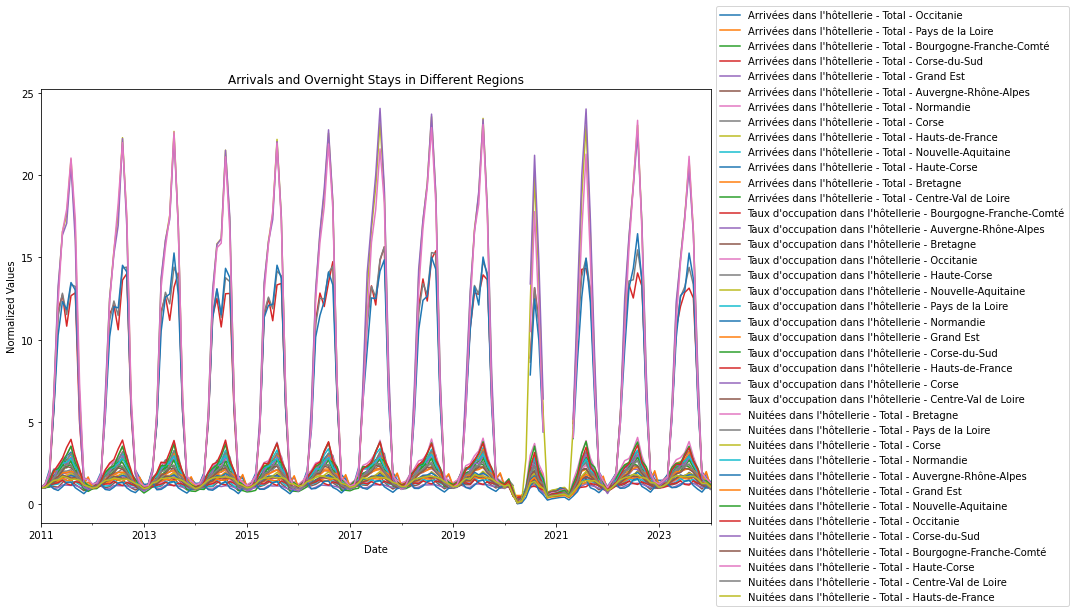

In [9]:
# Plotting overnight stays data
ax = overnight_stays_df_t.plot(figsize=(12, 8))
plt.title('Arrivals and Overnight Stays in Different Regions')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

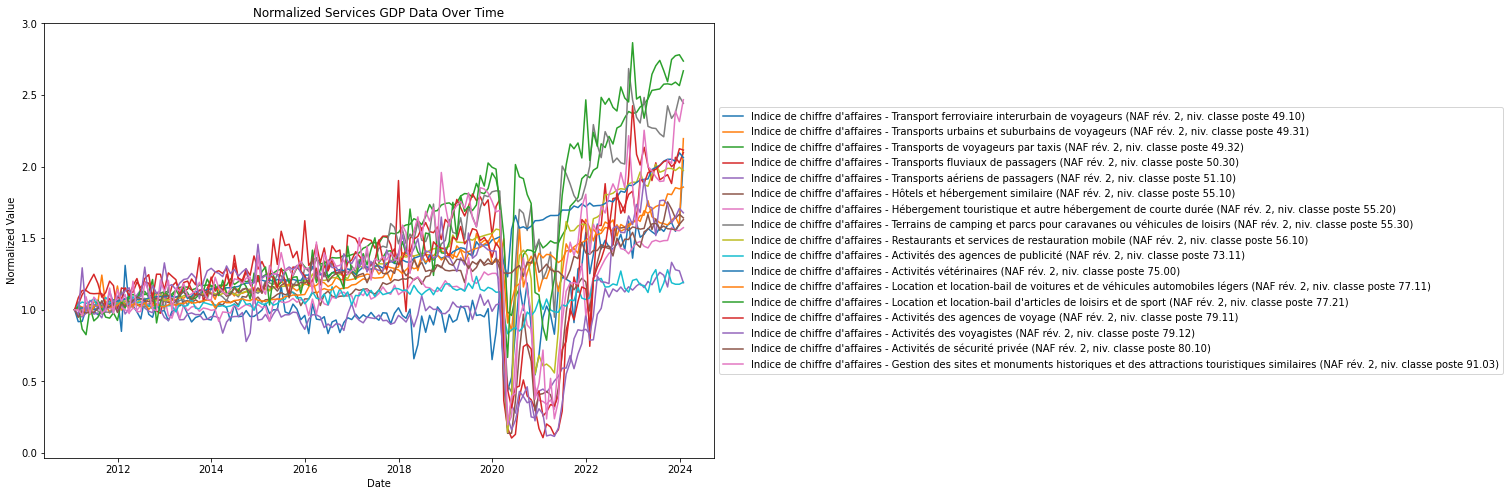

In [10]:
# Plotting toursim services GDP data
plt.figure(figsize=(12, 8))
for column in services_GDP_df_t.columns:
    plt.plot(services_GDP_df_t.index, services_GDP_df_t[column], label=column)
plt.title('Normalized Services GDP Data Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

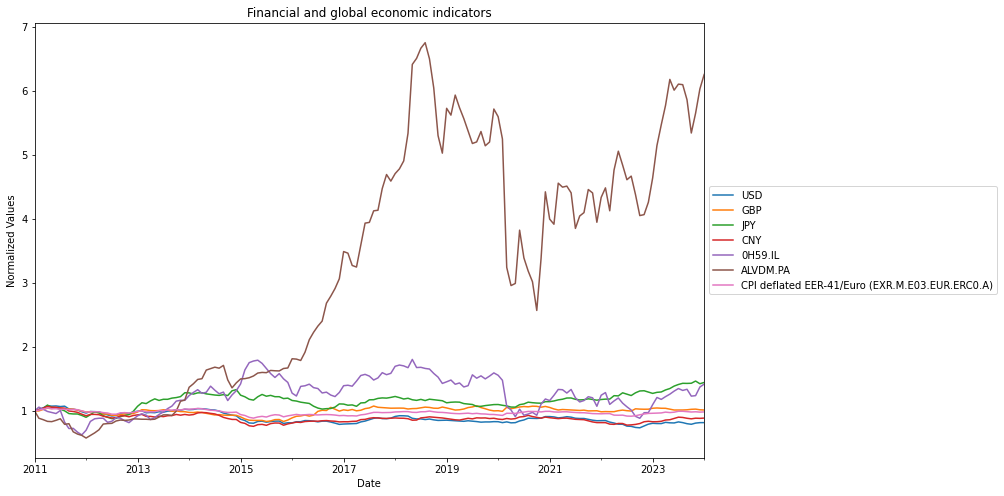

In [11]:
# Plotting financial and global economic indicators
ax = data[['USD','GBP','JPY','CNY','0H59.IL','ALVDM.PA','CPI deflated EER-41/Euro (EXR.M.E03.EUR.ERC0.A)']].plot(figsize=(12, 8))
plt.title('Financial and global economic indicators')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### iii) Séries de facteurs

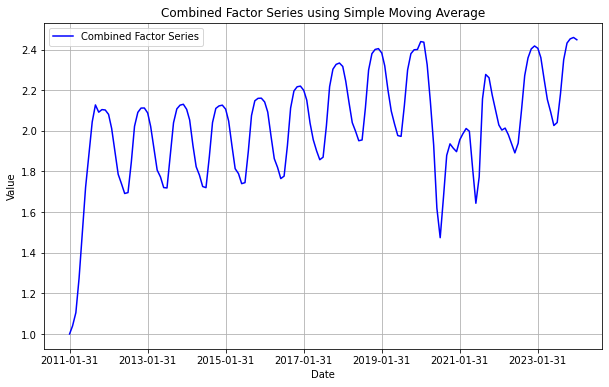

In [13]:
# Factor series using simple moving average
def calculate_sma(series, window=10):
    return series.rolling(window=window, min_periods=1).mean()  

facser = data.apply(calculate_sma)
comb_facser = facser.mean(axis=1)  

tick_frequency = 24
plt.figure(figsize=(10, 6))
plt.plot(comb_facser.index, comb_facser.values, label='Combined Factor Series', color='blue')
plt.title('Combined Factor Series using Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(comb_facser.index[::tick_frequency])
plt.show()

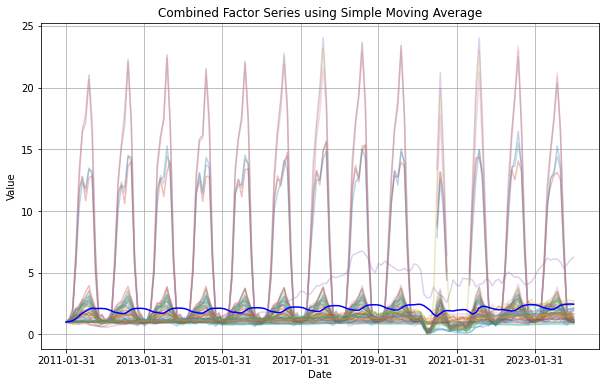

In [15]:
# Comparison of factor series with individual factors
plt.figure(figsize=(10, 6))
for column in data.columns:
    plt.plot(data.index, data[column].values, label=column, alpha=0.3)  
plt.plot(comb_facser.index, comb_facser.values, label='Combined Factor Series', color='blue')
plt.title('Combined Factor Series using Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.xticks(comb_facser.index[::tick_frequency])
plt.show()

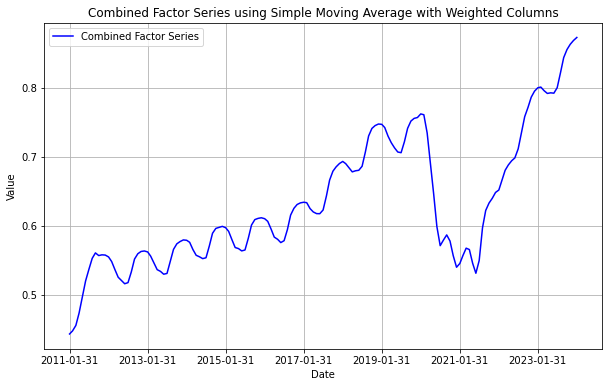

In [17]:
# Factor series using weighted simple moving average
def calculate_weighted_sma(series, window=10, weight=1):
    return series.rolling(window=window, min_periods=1).mean() * weight

weighted_facser = data.iloc[:, :39].apply(calculate_weighted_sma, weight=1/10)
weighted_facser_rest = data.iloc[:, 39:].apply(calculate_weighted_sma, weight=1)
facser = pd.concat([weighted_facser, weighted_facser_rest], axis=1)
comb_facser = facser.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(comb_facser.index, comb_facser.values, label='Combined Factor Series', color='blue')
plt.title('Combined Factor Series using Simple Moving Average with Weighted Columns')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(comb_facser.index[::tick_frequency])
plt.show()

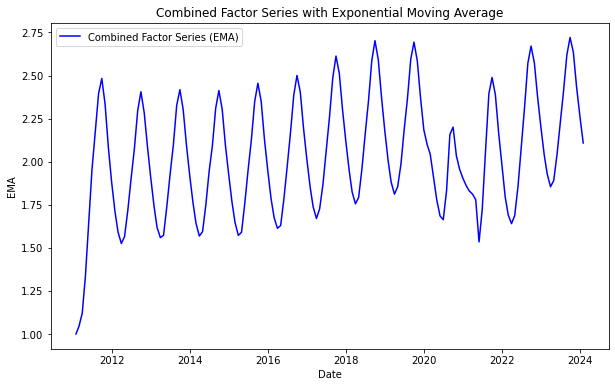

In [36]:
# Factor series using exponential moving average
span = 10 
ema_data = data.ewm(span=span).mean()
ema_data = ema_data.mean(axis=1)

plt.figure(figsize=(10, 6))

plt.plot(ema_data.index, ema_data.values, label='Combined Factor Series (EMA)', color='blue')

plt.title('Combined Factor Series with Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('EMA')
plt.legend()
plt.show()

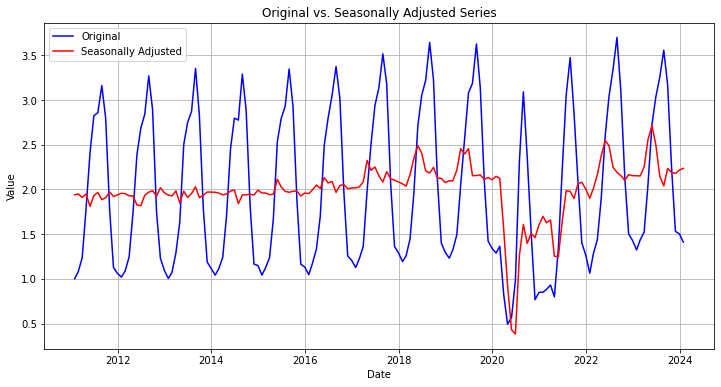

In [47]:
# Factor series using seasonal decomposition
data_mean = data.mean(axis=1)

stl = STL(data_mean, seasonal=13)  
res = stl.fit()

seasonally_adjusted = res.trend + res.resid

plt.figure(figsize=(12, 6))
plt.plot(data.index, data_mean, label='Original', color='blue')
plt.plot(data.index, seasonally_adjusted, label='Seasonally Adjusted', color='red')
plt.title('Original vs. Seasonally Adjusted Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

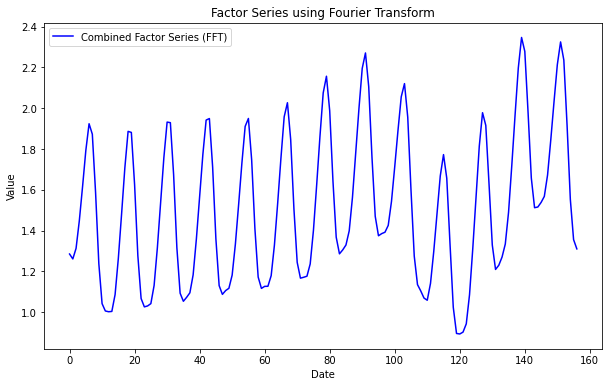

In [49]:
# Factor series using Fourier transform
def fourier_transform(data):
    fft_result = np.fft.fft(data)  
    frequencies = np.fft.fftfreq(len(data))  
    return fft_result, frequencies


def reconstruct_series(fft_result, frequencies, num_components=10):
    top_indices = np.argsort(np.abs(fft_result))[-num_components:]
    reconstructed_fft = np.zeros_like(fft_result)
    reconstructed_fft[top_indices] = fft_result[top_indices]
    reconstructed_series = np.fft.ifft(reconstructed_fft).real
    return reconstructed_series

factor_series_fft = {}
for column in data.columns:
    fft_result, frequencies = fourier_transform(data[column])
    reconstructed_series = reconstruct_series(fft_result, frequencies, num_components=10)
    factor_series_fft[column] = reconstructed_series

factor_series_fft = pd.DataFrame(factor_series_fft)
factor_series_fft = factor_series_fft.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(factor_series_fft.index, factor_series_fft.values, label='Combined Factor Series (FFT)', color='blue')
plt.title('Factor Series using Fourier Transform')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [20]:
# DFM using state space modeling
# Assuming a simple random walk model for the state equation: factor[t] = factor[t-1] + noise
def state_equation(factor, noise):
    return factor.shift(1) + noise

def observation_equation(factors, loadings):
    return factors.dot(loadings.T)

mod = sm.tsa.DynamicFactor(endog=data, k_factors=2, factor_order=1)

res = mod.fit(method='powell', disp=False)

print(res.summary())

forecast = res.get_prediction(start='2024-01-01', end='2024-12-31')
forecast_mean = forecast.predicted_mean

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [22]:

import pymc3 as pm

with pm.Model() as dfm_model:
    # Priors for factor loadings and factor variances
    factor_loadings = pm.Normal('factor_loadings', mu=0, sd=1, shape=(num_factors, num_variables))
    factor_variances = pm.HalfNormal('factor_variances', sd=1, shape=num_factors)
    
    # Prior for factor dynamics (random walk)
    factors = pm.GaussianRandomWalk('factors', mu=0, sd=1, shape=(num_factors, len(data)))
    
    # Observation equation
    mu = pm.math.dot(factor_loadings, factors)
    sigma = pm.HalfNormal('sigma', sd=1)
    likelihood = pm.Normal('likelihood', mu=mu, sd=sigma, observed=data.values)
    
with dfm_model:
    trace = pm.sample(2000, tune=1000)

pm.summary(trace)
pm.traceplot(trace)


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


ContextualVersionConflict: (numpy 1.22.4 (c:\users\utilisateur\anaconda3\lib\site-packages), Requirement.parse('numpy<1.22.2,>=1.15.0'), {'pymc3'})

### iv) Impact des politiques publiques et des évènements

In [79]:
# Define the indicator function for Vigipirate periods
vigipirate_periods = [
    (pd.to_datetime("2012-03-31"), pd.to_datetime("2012-03-31").replace(day=31)),
    (pd.to_datetime("2015-01-31"), pd.to_datetime("2015-01-31").replace(day=31)),
    (pd.to_datetime("2015-02-28"), pd.to_datetime("2015-02-28").replace(day=28)), 
    (pd.to_datetime("2015-06-30"), pd.to_datetime("2015-06-30").replace(day=30)),
    (pd.to_datetime("2015-11-30"), pd.to_datetime("2015-11-30").replace(day=30)),
    (pd.to_datetime("2016-03-31"), pd.to_datetime("2016-03-31").replace(day=31)),
    (pd.to_datetime("2016-06-30"), pd.to_datetime("2016-06-30").replace(day=30)),
    (pd.to_datetime("2016-07-31"), pd.to_datetime("2016-07-31").replace(day=31)),
    (pd.to_datetime("2016-09-30"), pd.to_datetime("2016-09-30").replace(day=30)),
    (pd.to_datetime("2017-06-30"), pd.to_datetime("2017-06-30").replace(day=30)),
    (pd.to_datetime("2017-09-30"), pd.to_datetime("2017-09-30").replace(day=30)),
    (pd.to_datetime("2018-02-28"), pd.to_datetime("2018-02-28").replace(day=28)),
    (pd.to_datetime("2018-12-31"), pd.to_datetime("2018-12-31").replace(day=31)),
    (pd.to_datetime("2021-03-31"), pd.to_datetime("2021-03-31").replace(day=31)),
    (pd.to_datetime("2023-10-31"), pd.to_datetime("2023-10-31").replace(day=31))
]

date_range = pd.date_range(start="2011-01-31", end="2024-01-31", freq="M")

vigipirate_indicator = []

for date in date_range:
    is_vigipirate_active = any(start <= date <= end for start, end in vigipirate_periods)
    vigipirate_indicator.append(1 if is_vigipirate_active else 0)

vigipirate_df = pd.DataFrame({
    "Date": date_range,
    "Vigipirate_Indicator": vigipirate_indicator
})

vigipirate_df.set_index("Date", inplace=True)
vigipirate_df

,Vigipirate_Indicator
Date,
2011-01-31,0
2011-02-28,0
2011-03-31,0
2011-04-30,0
2011-05-31,0
...,...
2023-09-30,0
2023-10-31,1
2023-11-30,0


In [80]:
# Define the indicator function for the NOTRe law

date_range = pd.date_range(start='2011-01-31', end='2024-01-31', freq='M')

law_effective_date = pd.to_datetime('2015-03-31')

indicator_data = {'Date': date_range,
                  'Loi_NOTRe_Indicator': (date_range >= law_effective_date).astype(int)}

indicator_df = pd.DataFrame(indicator_data)

indicator_df.set_index('Date', inplace=True)
indicator_df

,Loi_NOTRe_Indicator
Date,
2011-01-31,0
2011-02-28,0
2011-03-31,0
2011-04-30,0
2011-05-31,0
...,...
2023-09-30,1
2023-10-31,1
2023-11-30,1


In [81]:
# Define the indicator function for the COVID-19 pandemic
covid_periods = [
    (pd.to_datetime("2020-03-01"), pd.to_datetime("2021-12-31")) 
]

date_range = pd.date_range(start="2011-01-31", end="2024-01-31", freq="M")

covid_indicator = []

for date in date_range:
    is_covid_active = any(start <= date <= end for start, end in covid_periods)
    covid_indicator.append(1 if is_covid_active else 0)
covid_df = pd.DataFrame({
    "Date": date_range,
    "COVID_Indicator": covid_indicator
})

covid_df.set_index("Date", inplace=True)
covid_df

,COVID_Indicator
Date,
2011-01-31,0
2011-02-28,0
2011-03-31,0
2011-04-30,0
2011-05-31,0
...,...
2023-09-30,0
2023-10-31,0
2023-11-30,0


In [82]:
# Regression between Vigipirate indicator and factor series
X = sm.add_constant(vigipirate_df)
model = sm.OLS(comb_facser, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1140
Date:                Wed, 03 Apr 2024   Prob (F-statistic):              0.736
Time:                        14:11:23   Log-Likelihood:                -11.940
No. Observations:                 157   AIC:                             27.88
Df Residuals:                     155   BIC:                             33.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.0253 

In [83]:
# Regression between NOTRe law indicator and factor series
X = sm.add_constant(indicator_df)
model = sm.OLS(comb_facser, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     27.53
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           5.00e-07
Time:                        14:11:51   Log-Likelihood:                0.83770
No. Observations:                 157   AIC:                             2.325
Df Residuals:                     155   BIC:                             8.437
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.8792    

In [84]:
# Regression between COVID-19 indicator and factor series
X = sm.add_constant(covid_df)
model = sm.OLS(comb_facser, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.142
Date:                Wed, 03 Apr 2024   Prob (F-statistic):              0.145
Time:                        14:12:11   Log-Likelihood:                -10.921
No. Observations:                 157   AIC:                             25.84
Df Residuals:                     155   BIC:                             31.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.0399      0.022     

In [85]:
# Regression between all indicators and factor series
df = pd.concat([facser, vigipirate_df, indicator_df, covid_df], axis=1)
X = df[['Vigipirate_Indicator', 'Loi_NOTRe_Indicator', 'COVID_Indicator']]  
X = sm.add_constant(X) 
y =  comb_facser 
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# fair epour chaque indicatrice
# Faire pour la série sans saisonnalité

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     13.22
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.01e-07
Time:                        14:12:56   Log-Likelihood:                 6.0970
No. Observations:                 157   AIC:                            -4.194
Df Residuals:                     153   BIC:                             8.031
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8807 